In [ ]:
import os
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import missingno as msno
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
data_dir = '/content/drive/MyDrive/dog/data'
ds_name = 'Dog Breed'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Generate data paths with labels

def generate_data_paths(data_dir):

    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


filepaths, labels = generate_data_paths(data_dir)

In [ ]:
import os

In [ ]:
def create_df(filepaths, labels):

    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)
    return df

df = create_df(filepaths, labels)

In [ ]:
df.head()

filepaths              labels
0  /content/drive/MyDrive/dog/data/Norwegian_elkh...  Norwegian_elkhound
1  /content/drive/MyDrive/dog/data/Norwegian_elkh...  Norwegian_elkhound
2  /content/drive/MyDrive/dog/data/Norwegian_elkh...  Norwegian_elkhound
3  /content/drive/MyDrive/dog/data/Norwegian_elkh...  Norwegian_elkhound
4  /content/drive/MyDrive/dog/data/Norwegian_elkh...  Norwegian_elkhound

In [ ]:
def num_of_examples(df, name='df'):
    print(f"The {name} dataset has {df.shape[0]} images.")

num_of_examples(df, ds_name)

The Dog Breed dataset has 449 images.


In [ ]:
def num_of_classes(df, name='df'):
    print(f"The {name} dataset has {len(df['labels'].unique())} classes")

num_of_classes(df, ds_name)

The Dog Breed dataset has 6 classes


In [ ]:
def classes_count(df, name='df'):

    print(f"The {name} dataset has: ")
    print("="*70)
    print()
    for name in df['labels'].unique():
        num_class = len(df['labels'][df['labels'] == name])
        print(f"Class '{name}' has {num_class} images")
        print('-'*70)

classes_count(df, ds_name)

The Dog Breed dataset has: 

Class 'Norwegian_elkhound' has 75 images
----------------------------------------------------------------------
Class 'Bedlington_terrier' has 75 images
----------------------------------------------------------------------
Class 'Gordon_setter' has 75 images
----------------------------------------------------------------------
Class 'Dandie_Dinmont' has 75 images
----------------------------------------------------------------------
Class 'Ibizan_hound' has 74 images
----------------------------------------------------------------------
Class 'Bernese_mountain_dog' has 75 images
----------------------------------------------------------------------


In [ ]:
def cat_summary_with_graph(dataframe, col_name):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Countplot', 'Percentages'),
                        specs=[[{"type": "xy"}, {'type': 'domain'}]])

    fig.add_trace(go.Bar(y=dataframe[col_name].value_counts().values.tolist(),
                         x=[str(i) for i in dataframe[col_name].value_counts().index],
                         text=dataframe[col_name].value_counts().values.tolist(),
                         textfont=dict(size=15),
                         name=col_name,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(color=colors,
                                     line=dict(color='#DBE6EC',
                                               width=1))),
                  row=1, col=1)

    fig.add_trace(go.Pie(labels=dataframe[col_name].value_counts().keys(),
                         values=dataframe[col_name].value_counts().values,
                         textfont=dict(size=20),
                         textposition='auto',
                         showlegend=False,
                         name=col_name,
                         marker=dict(colors=colors)),
                  row=1, col=2)

    fig.update_layout(title={'text': col_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)


colors = ['#494BD3', '#E28AE2', '#F1F481', '#79DB80', '#DF5F5F',
              '#69DADE', '#C2E37D', '#E26580', '#D39F49', '#B96FE3']

cat_summary_with_graph(df,'labels')


In [ ]:
def check_null_values(df, name='df'):

    num_null_vals = sum(df.isnull().sum().values)

    if not num_null_vals:
        print(f"The {name} dataset has no null values")

    else:
        print(f"The {name} dataset has {num_null_vals} null values")
        print('-'*70)
        print('Total null values in each column:\n')
        print(df.isnull().sum())


check_null_values(df, ds_name)

The Dog Breed dataset has no null values


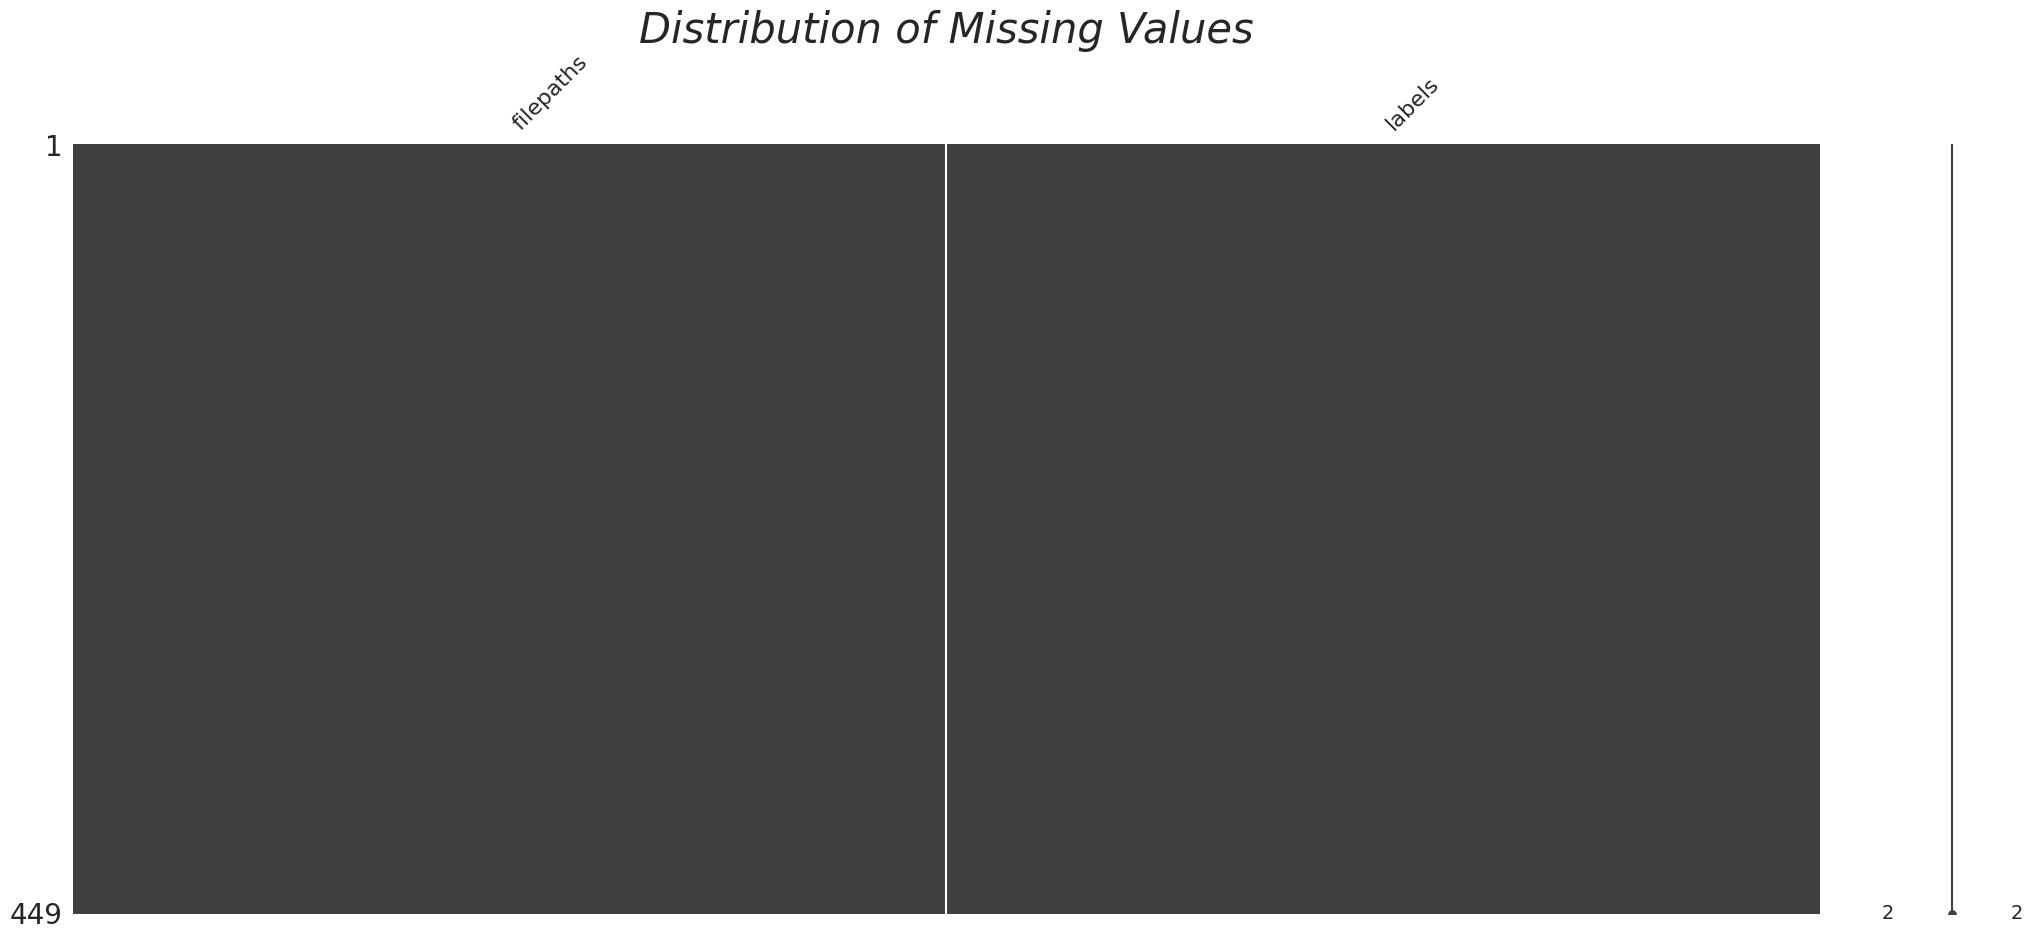

In [ ]:
msno.matrix(df)
plt.title('Distribution of Missing Values', fontsize=30, fontstyle='oblique');

In [ ]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [ ]:
num_of_classes(train_df, "Training "+ds_name)
num_of_classes(valid_df, "Validation "+ds_name)
num_of_classes(test_df, "Testing "+ds_name)

The Training Dog Breed dataset has 6 classes
The Validation Dog Breed dataset has 6 classes
The Testing Dog Breed dataset has 6 classes


In [ ]:
classes_count(train_df, 'Training '+ds_name)

The Training Dog Breed dataset has: 

Class 'Ibizan_hound' has 58 images
----------------------------------------------------------------------
Class 'Bedlington_terrier' has 64 images
----------------------------------------------------------------------
Class 'Bernese_mountain_dog' has 63 images
----------------------------------------------------------------------
Class 'Norwegian_elkhound' has 57 images
----------------------------------------------------------------------
Class 'Dandie_Dinmont' has 56 images
----------------------------------------------------------------------
Class 'Gordon_setter' has 61 images
----------------------------------------------------------------------


In [ ]:
classes_count(valid_df, 'Validation '+ds_name)

The Validation Dog Breed dataset has: 

Class 'Dandie_Dinmont' has 14 images
----------------------------------------------------------------------
Class 'Bedlington_terrier' has 7 images
----------------------------------------------------------------------
Class 'Norwegian_elkhound' has 12 images
----------------------------------------------------------------------
Class 'Ibizan_hound' has 8 images
----------------------------------------------------------------------
Class 'Bernese_mountain_dog' has 6 images
----------------------------------------------------------------------
Class 'Gordon_setter' has 7 images
----------------------------------------------------------------------


In [ ]:
classes_count(test_df, 'Testing '+ds_name)

The Testing Dog Breed dataset has: 

Class 'Bedlington_terrier' has 4 images
----------------------------------------------------------------------
Class 'Gordon_setter' has 7 images
----------------------------------------------------------------------
Class 'Dandie_Dinmont' has 5 images
----------------------------------------------------------------------
Class 'Norwegian_elkhound' has 6 images
----------------------------------------------------------------------
Class 'Ibizan_hound' has 8 images
----------------------------------------------------------------------
Class 'Bernese_mountain_dog' has 6 images
----------------------------------------------------------------------


In [ ]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

ts_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

train_gen = tr_gen.flow_from_dataframe(train_df,
                                       x_col= 'filepaths',
                                       y_col= 'labels',
                                       target_size= img_size,
                                       class_mode= 'categorical',
                                       color_mode= 'rgb',
                                       shuffle= True,
                                       batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df,
                                       x_col= 'filepaths',
                                       y_col= 'labels',
                                       target_size= img_size,
                                       class_mode= 'categorical',
                                       color_mode= 'rgb',
                                       shuffle= True,
                                       batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe(test_df,
                                      x_col= 'filepaths',
                                      y_col= 'labels',
                                      target_size= img_size,
                                      class_mode= 'categorical',
                                      color_mode= 'rgb',
                                      shuffle= False,
                                      batch_size= test_batch_size)

Found 359 validated image filenames belonging to 6 classes.
Found 54 validated image filenames belonging to 6 classes.
Found 36 validated image filenames belonging to 6 classes.


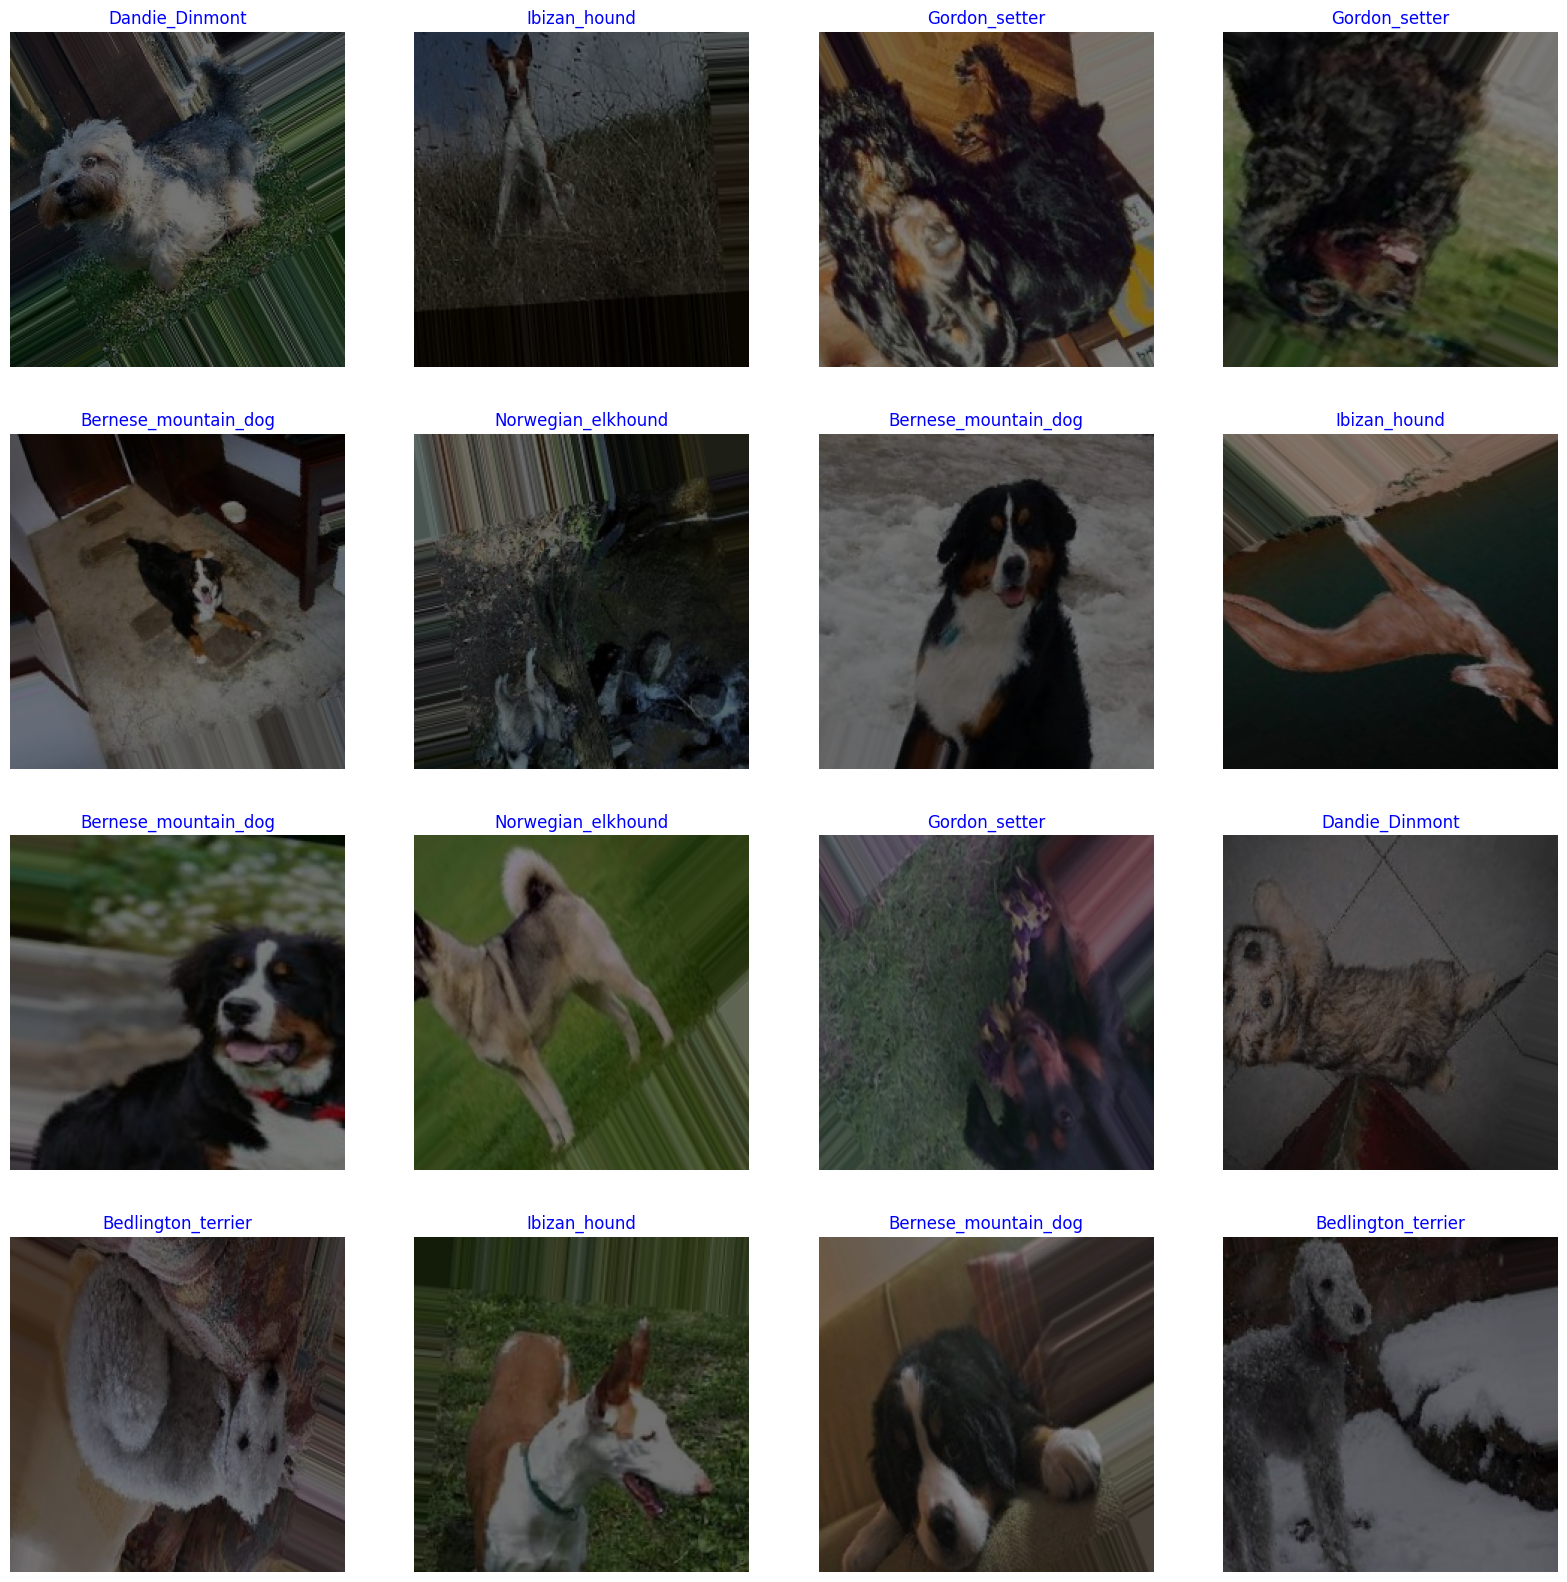

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')

plt.show()

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(128, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

115263384/115263384 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional  (None, 2048)              28513527  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                       

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5,
                               restore_best_weights=True,
                               mode='max',
                              )

def step_decay(epoch):

     initial_lrate = 0.1
     drop = 0.5
     epochs_drop = 10.0
     lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
     return lrate

lr_scheduler = LearningRateScheduler(step_decay)

In [ ]:
tf.__version__

'2.15.0'

In [ ]:
batch_size = 40   # set batch size for training
epochs = 15   # number of all epochs in training

history = model.fit(x=train_gen,
                    epochs= epochs,
                    verbose= 1,
                    validation_data= valid_gen,
                    validation_steps= None,
                    shuffle= False)

Epoch 1/15
23/23 [==============================] - 179s 7s/step - loss: 5.0131 - accuracy: 0.7493 - val_loss: 5.2740 - val_accuracy: 0.9074
Epoch 2/15
23/23 [==============================] - 129s 6s/step - loss: 4.4640 - accuracy: 0.8858 - val_loss: 4.8197 - val_accuracy: 0.8889
Epoch 3/15
23/23 [==============================] - 133s 6s/step - loss: 4.2296 - accuracy: 0.8858 - val_loss: 4.4675 - val_accuracy: 0.9444
Epoch 4/15
23/23 [==============================] - 129s 6s/step - loss: 3.9855 - accuracy: 0.9304 - val_loss: 4.1078 - val_accuracy: 0.9630
Epoch 5/15
23/23 [==============================] - 141s 6s/step - loss: 3.8217 - accuracy: 0.9387 - val_loss: 3.7868 - val_accuracy: 0.9444
Epoch 6/15
23/23 [==============================] - 128s 6s/step - loss: 3.6402 - accuracy: 0.9471 - val_loss: 3.5935 - val_accuracy: 0.9630
Epoch 7/15
23/23 [==============================] - 119s 5s/step - loss: 3.5100 - accuracy: 0.9471 - val_loss: 3.4797 - val_accuracy: 0.9444
Epoch 8/15
23

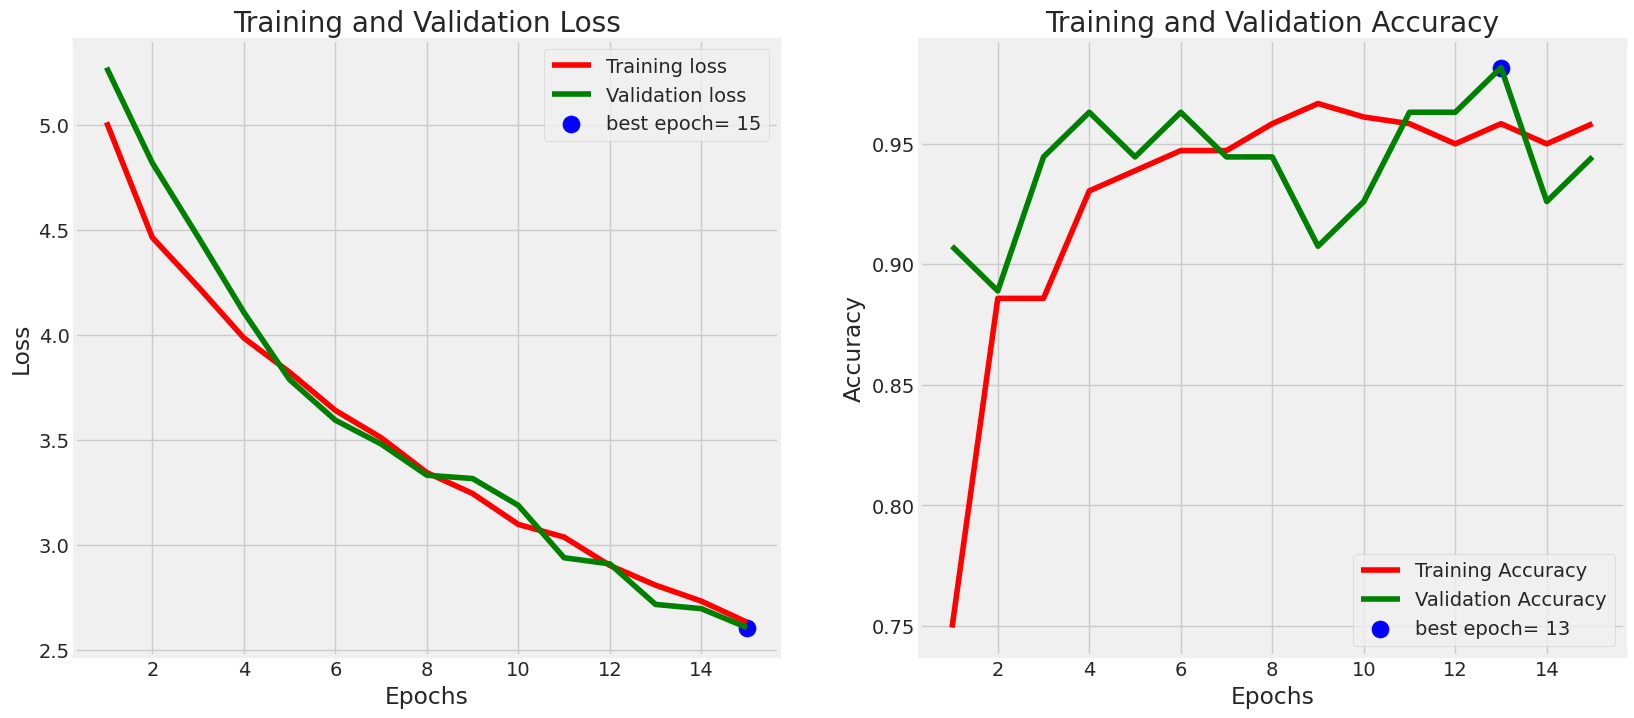

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 12s 12s/step - loss: 2.5394 - accuracy: 0.9722
Train Loss:  2.4947900772094727
Train Accuracy:  1.0
--------------------
Validation Loss:  2.823012113571167
Validation Accuracy:  0.875
--------------------
Test Loss:  2.539360523223877
Test Accuracy:  0.9722222089767456


In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

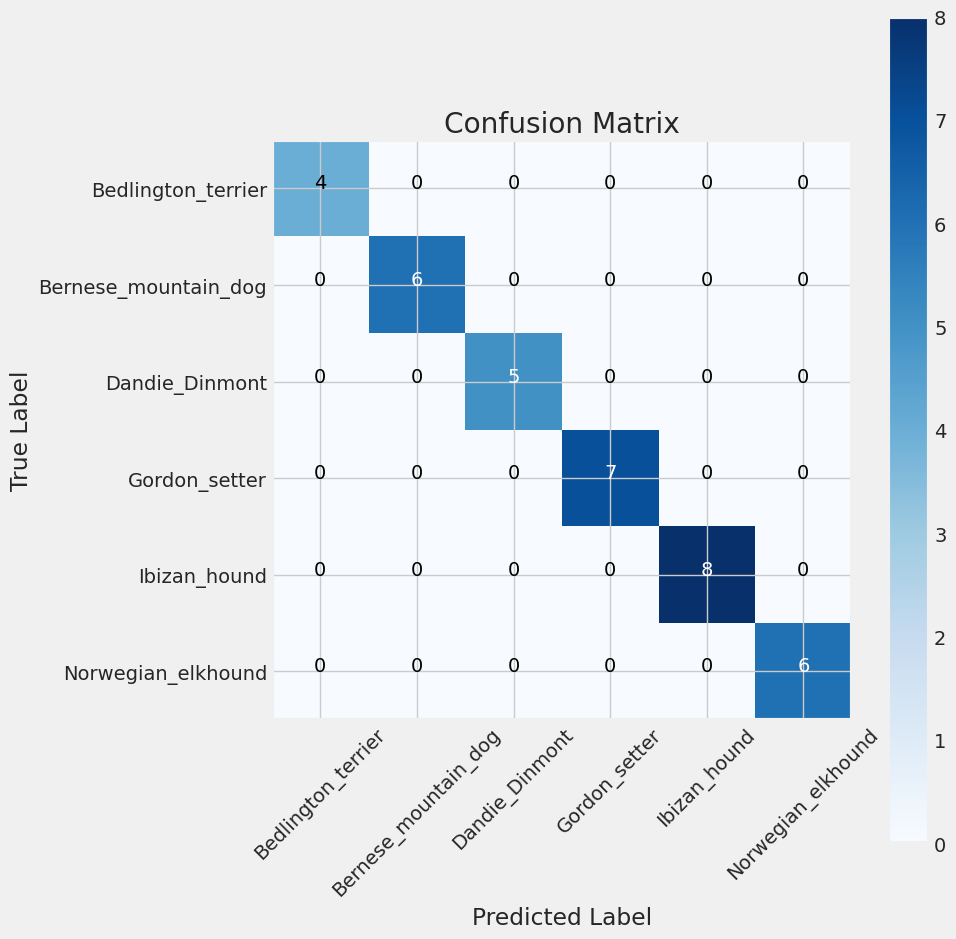

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                      precision    recall  f1-score   support

  Bedlington_terrier       1.00      1.00      1.00         4
Bernese_mountain_dog       1.00      1.00      1.00         6
      Dandie_Dinmont       1.00      1.00      1.00         5
       Gordon_setter       1.00      1.00      1.00         7
        Ibizan_hound       1.00      1.00      1.00         8
  Norwegian_elkhound       1.00      1.00      1.00         6

            accuracy                           1.00        36
           macro avg       1.00      1.00      1.00        36
        weighted avg       1.00      1.00      1.00        36



In [ ]:
# Save just the weights
model.save_weights('my_model_weights.h5')

1/1 [==============================] - 5s 5s/step


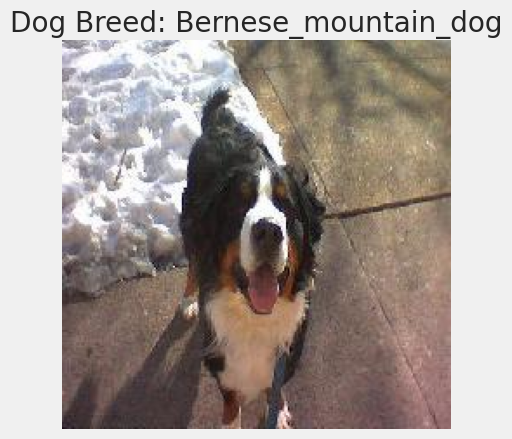

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

def predict_dogBreed(image_path, model):

    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)

    class_indices = train_gen.class_indices
    class_labels = list(class_indices.keys())
    predicted_class_label = class_labels[predicted_class_index]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Dog Breed: {predicted_class_label}")
    plt.show()

    return predicted_class_label, prediction[0]

# Load your trained model
# Replace 'path_to_your_model' with the actual path to your trained model's weights
model.load_weights('/content/my_model_weights.h5')

# Replace 'path_to_test_image' with the path to the image you want to test
image_path_to_test = '/content/Bernese_mountain_dog_99.jpg'
predicted_class_label, prediction = predict_dogBreed(image_path_to_test, model)

1/1 [==============================] - 0s 403ms/step


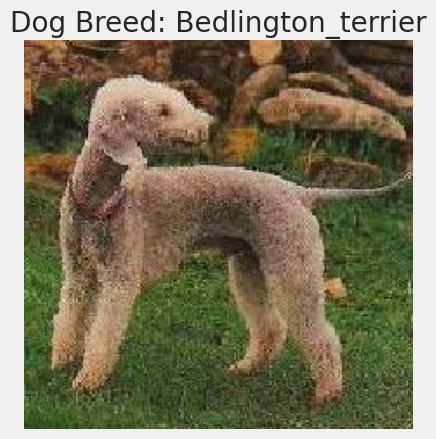

In [ ]:
image_path_to_test = '/content/Bedlington_terrier_14.jpg'
predicted_class_label, prediction = predict_dogBreed(image_path_to_test, model)

1/1 [==============================] - 0s 359ms/step


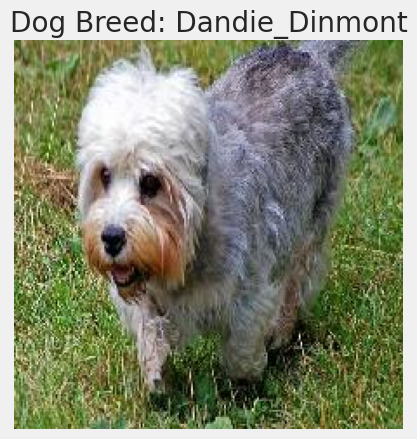

In [ ]:
image_path_to_test = '/content/Dandie_Dinmont_16.jpg'
predicted_class_label, prediction = predict_dogBreed(image_path_to_test, model)



In [ ]:
import tensorflow as tf
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


In [ ]:
from tensorflow.keras.models import Model

# Load pre-trained EfficientNetB5 without top layer
base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')

# Extract features using pre-trained model
feature_extractor = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

# Function to extract features from images
def extract_features(img_path):
    img = image.load_img(img_path, target_size=(img_size[0], img_size[1]))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    features = feature_extractor.predict(np.expand_dims(img_array, axis=0))
    return features


In [ ]:
# Extract features for all images
X_train = np.array([extract_features(path) for path in train_df['filepaths']])
X_valid = np.array([extract_features(path) for path in valid_df['filepaths']])
X_test = np.array([extract_features(path) for path in test_df['filepaths']])

# Convert labels to one-hot encoded vectors
y_train = tf.keras.utils.to_categorical(train_df['labels'].map(train_gen.class_indices), num_classes=class_count)
y_valid = tf.keras.utils.to_categorical(valid_df['labels'].map(train_gen.class_indices), num_classes=class_count)
y_test = tf.keras.utils.to_categorical(test_df['labels'].map(train_gen.class_indices), num_classes=class_count)


1/1 [==============================] - 0s 232ms/step


In [ ]:
from sklearn.svm import SVC

# Flatten feature matrices
X_train_flatten = X_train.reshape(X_train.shape[0], -1)
X_valid_flatten = X_valid.reshape(X_valid.shape[0], -1)
X_test_flatten = X_test.reshape(X_test.shape[0], -1)

# Initialize and train SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_flatten, np.argmax(y_train, axis=1))


SVC(kernel='linear')

In [ ]:
svm_valid_accuracy = svm_classifier.score(X_valid_flatten, np.argmax(y_valid, axis=1))
svm_test_accuracy = svm_classifier.score(X_test_flatten, np.argmax(y_test, axis=1))

print("SVM Validation Accuracy:", svm_valid_accuracy)
print("SVM Test Accuracy:", svm_test_accuracy)


SVM Validation Accuracy: 0.9814814814814815
SVM Test Accuracy: 1.0
